# Market quota game

## Simulating SNP500 data

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
r = 0.01
sigma = 0.1474
S0 = 100
mu = r - sigma*sigma/2
delta = 1/365

In [20]:
def geom_brownian_motion(S0, mu, sigma, delta):
    S = [S0]
    for _ in range(int(1//delta)):
        X = S[-1] * np.exp(delta * mu + np.sqrt(delta) * sigma * np.random.standard_normal())
        S.append(X)
    return S

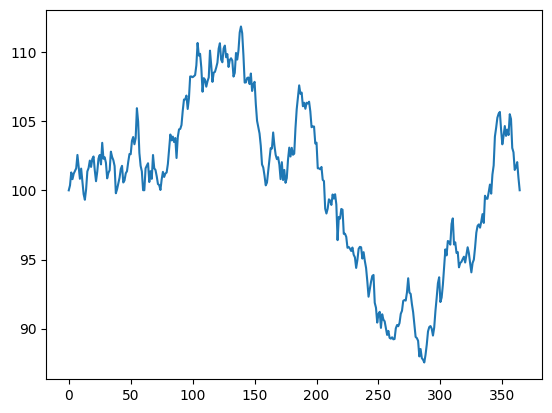

In [21]:
plt.plot(geom_brownian_motion(S0, mu, sigma, delta))